# Bulk Website Validation

#### 1 - Creating Functions

In [ ]:
#---- Importing Packages
import requests
import json
import pandas as pd
import os
from datetime import date
from urllib.parse import urlparse
import tldextract
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import time
import matplotlib.pyplot as plt

# --- Creating Functions

# Function to transform the URL
def make_https(url):
    if isinstance(url, str):
        # Remove "http://", "https://", and "www."
        url = url.replace("http://", "").replace("https://", "").replace("www.", "")
        # Extract only the domain and site name
        parsed_url = urlparse(url)
        return f"https://www.{parsed_url.netloc}{parsed_url.path}"
    else:
        return url

# Creating a session for persistent connections
session = requests.Session()

# Creating a get_status function that uses the session
def get_status(url):
    try:
        # Use the session for persistent connections
        response = session.get(url, timeout=10, allow_redirects=True)
        
        # Check the status code
        if response.status_code == 200:
            return 'valid'
        elif response.status_code == 404:
            return 'invalid'
        else:
            return 'other'
    except requests.Timeout:
        return 'timed out'
    except Exception as e:
        # Handle exceptions, if any
        return 'invalid'


#### 2 - Working with Data

In [31]:
# Record the start time
start_time = time.time()

# Importing data from the 'website' spreadsheet in the same directory as the script
df = pd.read_excel('website.xlsx')

# Data cleaning
df['URL'] = df['website'].apply(make_https)
df['URL'] = df['URL'].drop_duplicates().reset_index(drop=True)
df = df.dropna(subset=['URL']).reset_index(drop=True)
df = df.dropna(subset=['website']).reset_index(drop=True)

# Working with DataFrame df
chunk_size = 4  # Try different chunk sizes
chunks = [df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size)]

# Process the chunks in parallel using ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda chunk: chunk.assign(validation=chunk['URL'].map(get_status)), chunks))

# Concatenate the results
df = pd.concat(results, ignore_index=True)

# Saving to Excel
df.to_excel('verifiedDomains.xlsx', index=False)

# Record the end time
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 144.81593251228333 seconds


### 3 - Data Analysis

In [36]:
# Displaying the DataFrame with the new column
df.head()

,website,URL,validation
0,fonts.googleapis.com,https://www.fonts.googleapis.com,invalid
1,facebook.com,https://www.facebook.com,valid
2,twitter.com,https://www.twitter.com,valid
3,google.com,https://www.google.com,valid
4,youtube.com,https://www.youtube.com,valid


In [25]:
#Unique Values
unique_values = df['validation'].unique()

# Percentual counting
value_counts = df['validation'].value_counts()

# Calculating percentual
percentage = (value_counts / len(df)) * 100

# Creating Table
table = pd.DataFrame({'Validation Status': unique_values, 'Absolute Count': value_counts, 'Percentage': percentage})

# Show a tabela
print(table)


           Validation Status  Absolute Count  Percentage
validation                                              
valid                invalid             606   60.660661
invalid                valid             253   25.325325
other                  other             118   11.811812
timed out          timed out              22    2.202202


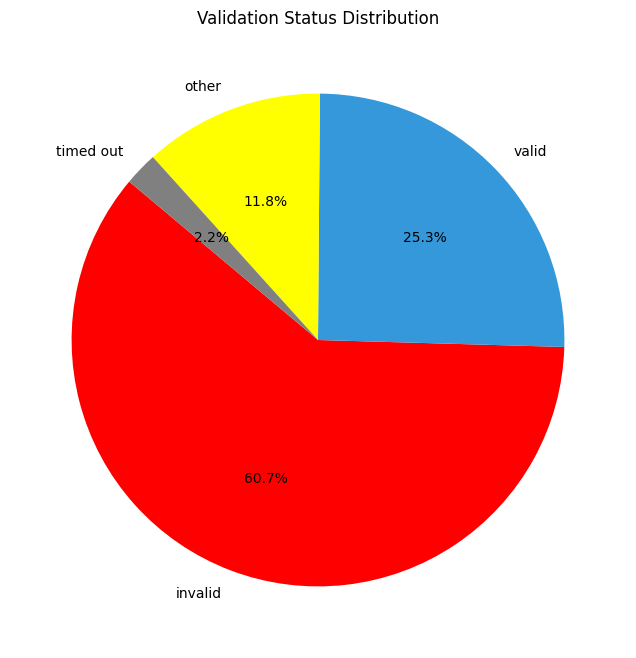

In [37]:
# Defining Categories
colors = {'valid': '#3498db', 'invalid': 'red', 'timed out': 'gray', 'other': 'yellow'}

# Creating chart
plt.figure(figsize=(8, 8))
plt.pie(percentage, labels=unique_values, autopct='%1.1f%%', startangle=140, colors=[colors[val.lower()] for val in unique_values])
plt.title('Validation Status Distribution')
plt.show()


## Summary of Data

### 1. Valid
- **Percentage:** Approximately 25.33%
- **Explanation:** Websites that returned a status code 200, indicating a successful response. Typically, this suggests that the site is active and accessible.

### 2. Invalid
- **Percentage:** About 60.66%
- **Explanation:** Websites that returned a status code 404, indicating that the page was not found. This may suggest that the site does not exist or is inactive.

### 3. Other
- **Percentage:** Approximately 11.81%
- **Explanation:** This category is assigned to websites that do not fall into the "Valid" or "Invalid" categories. It may include HTTP responses other than 200 or 404.

### 4. Timed Out
- **Percentage:** Around 2.20%
- **Explanation:** Websites for which the connection attempt exceeded the defined timeout (10 seconds in this case). This can occur due to a slow connection or connectivity issues.

### Additional Explanations
- **Validation:** Validation is performed using the returned HTTP status code after an HTTP request. A status code 200 is considered "Valid," while a status code 404 is considered "Invalid."
  
- **Other:** The "Other" category is a general designation for situations that do not fit into the main "Valid" or "Invalid" categories. This may include HTTP responses other than 200 or 404, or other unforeseen situations.
